In [7]:
#!pip install --upgrade mplfinance
!pip install TA-Lib

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
Failed to build TA-Lib


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Chengkf\anaconda3\python.exe' 'C:\Users\Chengkf\anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' build_wheel 'C:\Users\Chengkf\AppData\Local\Temp\tmp_t330kwg'
       cwd: C:\Users\Chengkf\AppData\Local\Temp\pip-install-vrv_0joa\ta-lib_240ea9be7f5b42fdb4d45f7cee7e33bb
  Complete output (20 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-38
  creating build\lib.win-amd64-cpython-38\talib
  copying talib\abstract.py -> build\lib.win-amd64-cpython-38\talib
  copying talib\deprecated.py -> build\lib.win-amd64-cpython-38\talib
  copying talib\stream.py -> build\lib.win-amd64-cpython-38\talib
  copying talib\test_abstract.py -> build\lib.win-amd64-cpython-38\talib
  copying talib\test_data.py -> build\lib.win-amd64-cpython-38\talib
  copying talib\test_func.py -> build\lib.win-amd64-cpython-38\talib
  copying talib\test_pandas.py -> buil

In [10]:
import time
import requests

import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

from talib import abstract
from datetime import datetime

In [14]:
# # Global Variables Setting
symbol = 'BTCUSDT'
url = 'https://api.binance.com/'

# # Get Market Data
def GetKline(url, symbol, interval, startTime = None, endTime = None):
    try:
        data = requests.get(url + 'api/v3/klines', params={'symbol': symbol, 'interval': interval, 'startTime': startTime, 'limit': 1000}).json()
    except Exception as e:
        print ('Error! problem is {}'.format(e.args[0]))
    tmp  = []
    pair = []
    for base in data:
        tmp  = []
        for i in range(0,6):
            if i == 0:
                base[i] = datetime.fromtimestamp(base[i]/1000)
            tmp.append(base[i])
        pair.append(tmp)
    df = pd.DataFrame(pair, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    df = df.astype(float)
    return df

def GetHistoricalKline(url, symbol, interval, startTime):
    # init
    klines = GetKline(url, symbol, interval)
    tmptime = ToMs(klines.iloc[0].name)
    
    # Send request until tmptime > startTime
    while tmptime > startTime:
        tmptime -= PeriodToMs(interval) * 1000 # tmp minus period ms plus 1000 (1000 K)
        if tmptime < startTime:
            tmptime = startTime
        tmpdata = GetKline(url, symbol, interval, tmptime)
        klines  = pd.concat([tmpdata, klines])

    return klines.drop_duplicates(keep='first', inplace=False)

# Math Tools
def ToMs(date):
    return int(time.mktime(time.strptime(str(date), "%Y-%m-%d %H:%M:%S")) * 1000) # Binance timestamp format is 13 digits

def PeriodToMs(period):
    Ms = None
    ToSeconds = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }
    unit = period[-1]

    if unit in ToSeconds:
        try:
            Ms = int(period[:-1]) * ToSeconds[unit] * 1000
        except ValueError:
            pass
    return Ms

In [15]:
if __name__ == "__main__":
    klines = GetHistoricalKline(url, symbol, '4h', ToMs('2019-05-01 12:00:00'))
    print (klines)

                         open      high       low     close         volume
date                                                                      
2019-05-01 12:00:00   5348.92   5357.00   5337.62   5353.40    1700.049906
2019-05-01 16:00:00   5352.60   5366.90   5326.05   5362.14    2492.910405
2019-05-01 20:00:00   5363.42   5364.00   5333.00   5355.35    2687.890665
2019-05-02 00:00:00   5355.34   5402.00   5342.75   5367.41    4460.837124
2019-05-02 04:00:00   5365.98   5393.54   5355.00   5383.20    1441.683741
...                       ...       ...       ...       ...            ...
2022-11-09 04:00:00  18255.24  18730.00  17810.49  18547.23   92742.313150
2022-11-09 08:00:00  18545.38  18587.76  18000.00  18313.68   91433.923990
2022-11-09 12:00:00  18313.68  18517.58  18173.09  18240.72   73860.208910
2022-11-09 16:00:00  18239.34  18256.85  17250.33  17818.08  152443.387350
2022-11-09 20:00:00  17817.07  18015.00  17005.00  17143.97  132794.456333

[7727 rows x 5 columns]


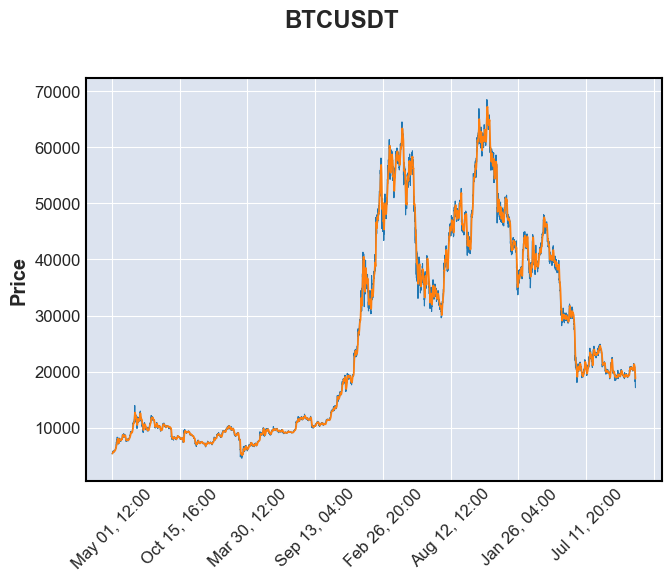

In [19]:
# # Financial indicators

def MACD(df, period):
    return abstract.DEMA(df, timeperiod=period)

def DMI(df, period):
    return abstract.EMA(df, timeperiod=period)

def SMA(df, period):
    return abstract.SMA(df, timeperiod=period)

def RSI(df, period):
    return abstract.RSI(df, timeperiod=period)


index  = mpf.make_addplot(SMA(klines, 10))
mpf.plot(klines, type = 'line', title = symbol, addplot = [index])

C:\Users\Chengkf\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


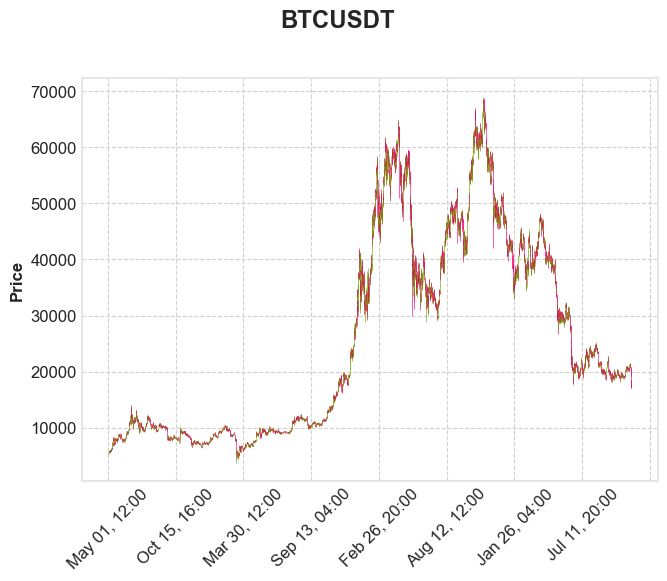

In [21]:
mpf.plot(klines, type = 'candle', style = 'binance', title = symbol)#, addplot = [index], volume = True)

open bb 
mplfinance
talib
personal: Tvdatafeed
Pynance
Pyfolio 
Zipline
Quandl

https://financetrain.com/best-python-librariespackages-finance-financial-data-scientists

PyAlgoTrade
Finmarketpy 
plotly dash

volib https://github.com/vollib/vollib
QuantPy https://github.com/jsmidt/QuantPy
tia https://github.com/bpsmith/tia
https://towardsdatascience.com/python-for-finance-7-useful-libraries-that-you-should-know-e422b9e9aaba